# Analaysis of filter type and their effect on readout

Modified from casper's PFB Introduction book. See [This repsitory](https://github.com/telegraphic/pfb_introduction/tree/master)

In [1]:

# Import required modules
import numpy as np
import scipy
from scipy.signal import firwin, freqz, lfilter
import matplotlib.pyplot as plt

def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)

In [2]:
def pfb_fir_frontend(x, win_coeffs, M, P):
    W = int(x.shape[0] / M / P)
    x_p = x.reshape((W*M, P)).T
    h_p = win_coeffs.reshape((M, P)).T
    x_summed = np.zeros((P, M * W - M))
    for t in range(0, M*W-M):
        x_weighted = x_p[:, t:t+M] * h_p
        x_summed[:, t] = x_weighted.sum(axis=1)
    return x_summed.T

In [3]:
def generate_win_coeffs(M, P, window_fn="hamming"):
    win_coeffs = scipy.signal.get_window(window_fn, M*P)
    sinc       = scipy.signal.firwin(M * P, cutoff=1.0/P, window="rectangular")
    win_coeffs *= sinc
    return win_coeffs


In [4]:
# CONSTANTS
M     = 4          # Number of taps
P     = 1024       # Number of 'branches', also fft length
W     = 1000       # Number of windows of length M*P in input time stream
n_int = 2          # Number of time integrations on output data
WIN_SINC = scipy.signal.firwin(M * P, cutoff=1.0/P, window="rectangular")
WIN_HAMMING = generate_win_coeffs(M, P, "hamming")
WIN_BOXCAR = generate_win_coeffs(M, P, "boxcar")
WIN_TRIANG = generate_win_coeffs(M, P, "triang")
WIN_BLACKMAN = generate_win_coeffs(M, P, "blackman")
WIN_HANN = generate_win_coeffs(M, P, "hann")
WIN_BARTLETT = generate_win_coeffs(M, P, "bartlett")
WIN_FLATTOP = generate_win_coeffs(M, P, "flattop")
WIN_PARZEN = generate_win_coeffs(M, P, "parzen")
WIN_BOHMAN = generate_win_coeffs(M, P, "bohman")
WIN_BLACKMANHARRIS = generate_win_coeffs(M, P, "blackmanharris")
WIN_NUTTALL = generate_win_coeffs(M, P, "nuttall")
WIN_BARTHANN = generate_win_coeffs(M, P, "barthann")
WIN_COSINE = generate_win_coeffs(M, P, "cosine")
WIN_EXPONENTIAL = generate_win_coeffs(M, P, "exponential")
WIN_TUKEY = generate_win_coeffs(M, P, "tukey")
WIN_TAYLOR = generate_win_coeffs(M, P, "taylor")
WIN_LANCZOS = generate_win_coeffs(M, P, "lanczos")


windowList = [WIN_SINC,WIN_HAMMING,WIN_BOXCAR,WIN_TRIANG,WIN_BLACKMAN,WIN_HANN,WIN_BARTLETT,
              WIN_FLATTOP,WIN_PARZEN,WIN_BOHMAN,WIN_BLACKMANHARRIS,WIN_NUTTALL,WIN_BARTHANN,
              WIN_COSINE,WIN_EXPONENTIAL,WIN_TUKEY,WIN_TAYLOR, WIN_LANCZOS
            ]
names = [
"SINC","HAMMING","BOXCAR","TRIANG","BLACKMAN","HANN","BARTLETT","FLATTOP","PARZEN","BOHMAN",
"BLACKMANHARRIS","NUTTALL","BARTHANN","COSINE","EXPONENTIAL","TUKEY","TAYLOR","LANCZOS"]

In [5]:
def fft(x_p, P, axis=1):
    return np.fft.fft(x_p, P, axis=axis)

def pfb_spectrometer(x, n_taps, n_chan, n_int, win_coeffs):
    M = n_taps
    P = n_chan
    
    # Apply frontend, take FFT, then take power (i.e. square)
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P)
    x_pfb = fft(x_fir, P)
    x_psd = np.abs(x_pfb)**2
    
    # Trim array so we can do time integration
    x_psd = x_psd[:np.round(x_psd.shape[0]//n_int)*n_int]
    
    # Integrate over time, by reshaping and summing over axis (efficient)
    x_psd = x_psd.reshape(x_psd.shape[0]//n_int, n_int, x_psd.shape[1])
    x_psd = x_psd.mean(axis=1)
    
    return x_psd



/home/carobers/sidequests/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/carobers/sidequests/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


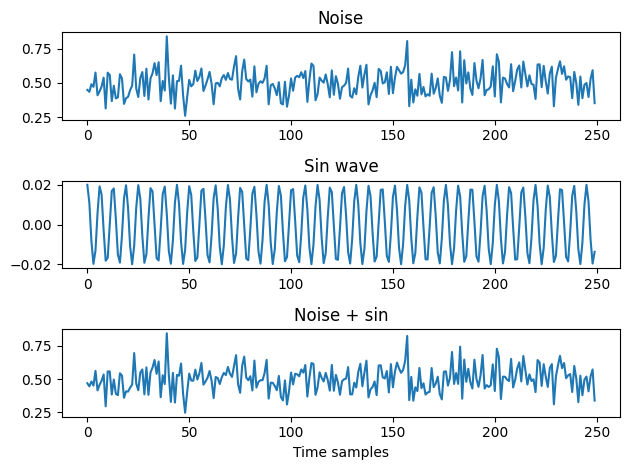

In [8]:
# Generate a test data steam
samples = np.arange(M*P*W)
noise   = np.random.normal(loc=0.5, scale=0.1, size=M*P*W) 
freq = 1
amp  = 0.02
cw_signal = amp * (np.cos(samples * freq) + 1j*np.sin(samples*freq))
data = noise + cw_signal

plt.subplot(3,1,1)
plt.title("Noise")
plt.plot(noise[:250])
plt.subplot(3,1,2)
plt.title("Sin wave")
plt.plot(cw_signal[:250])
plt.subplot(3,1,3)
plt.title("Noise + sin")
plt.plot(data[:250])
plt.xlabel("Time samples")
plt.tight_layout()
plt.show()

/tmp/ipykernel_446731/1727466042.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  x_summed[:, t] = x_weighted.sum(axis=1)


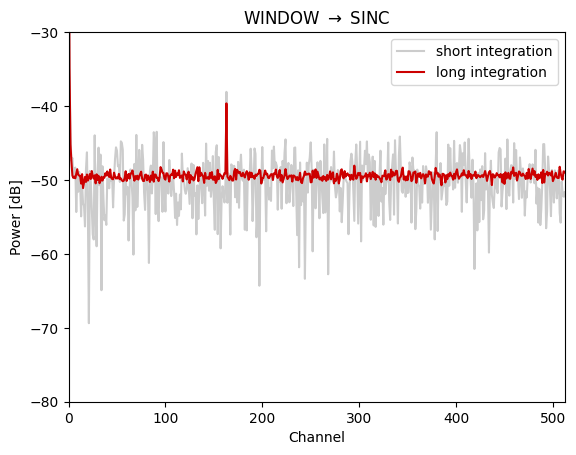

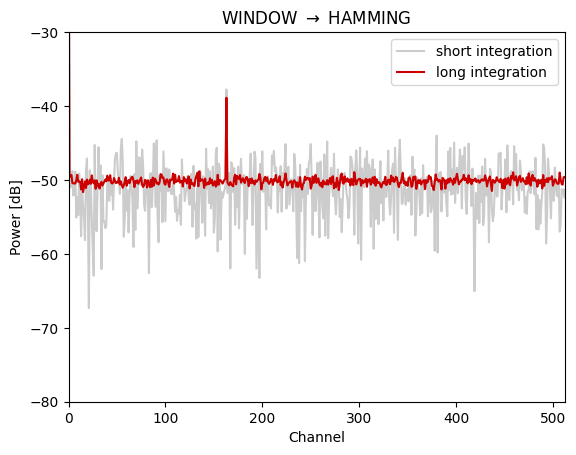

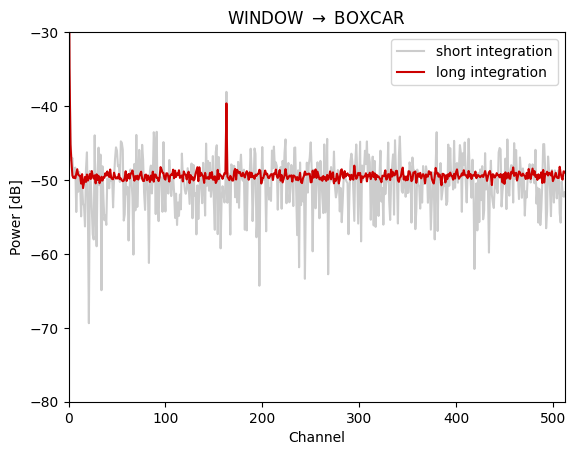

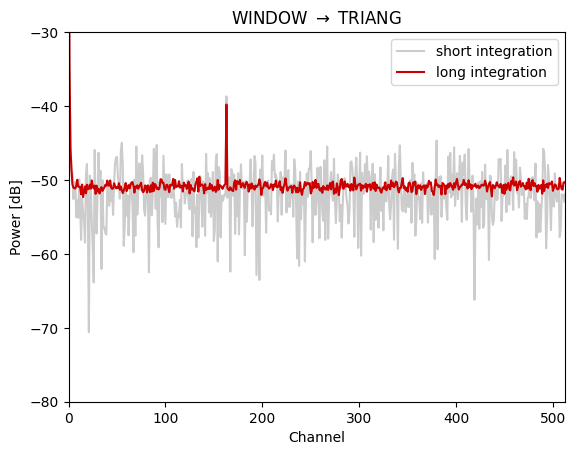

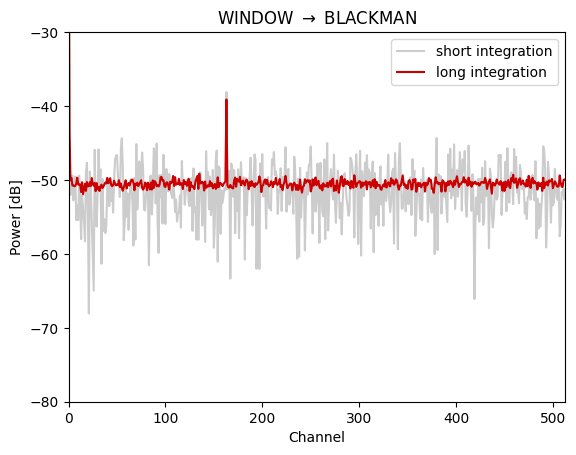

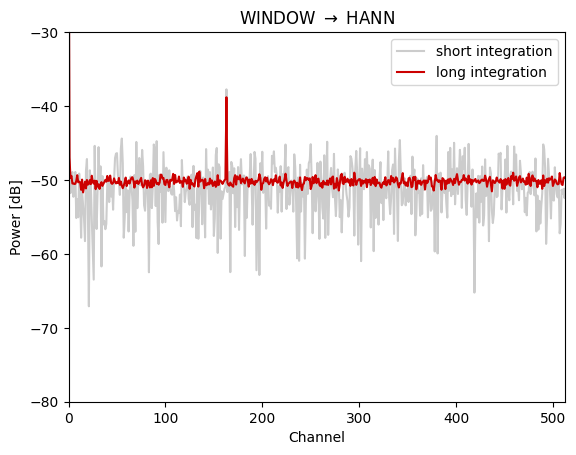

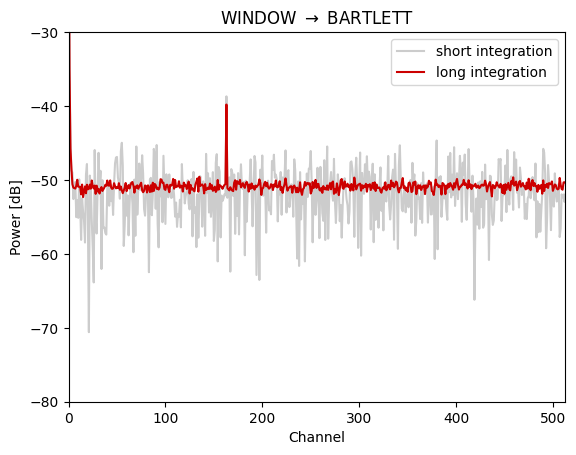

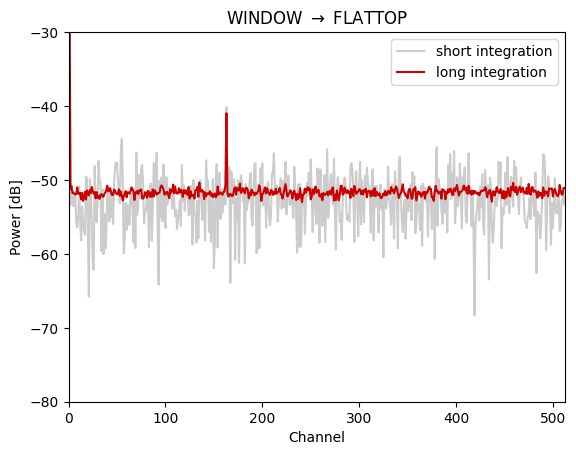

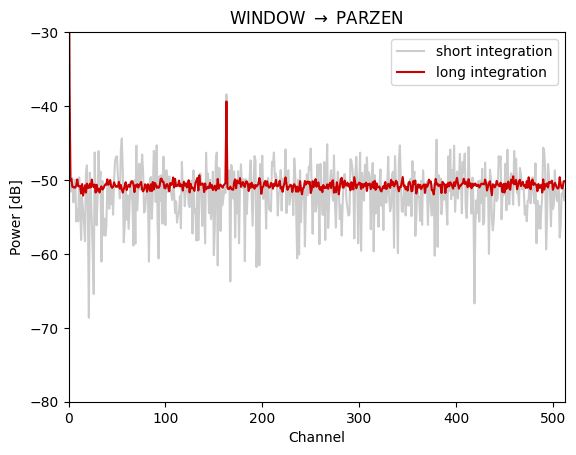

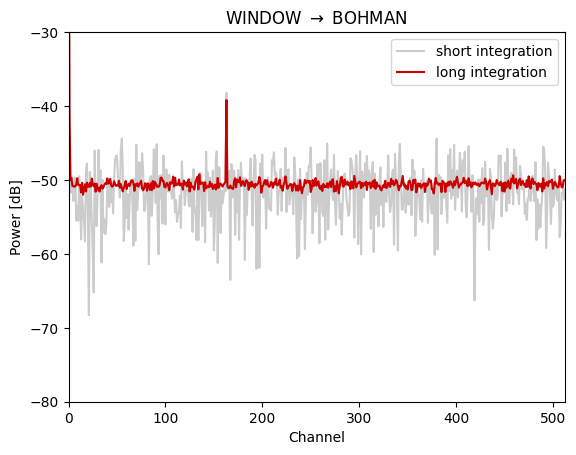

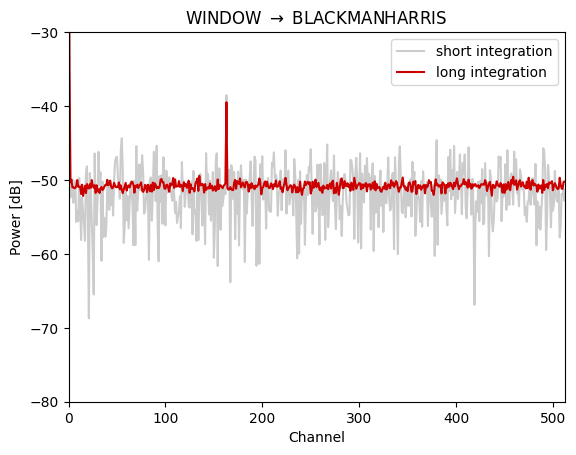

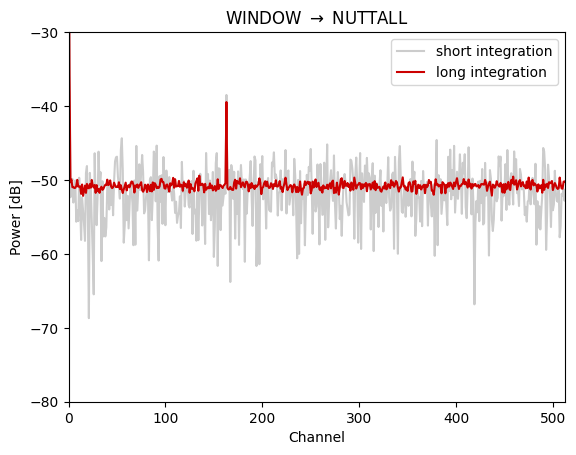

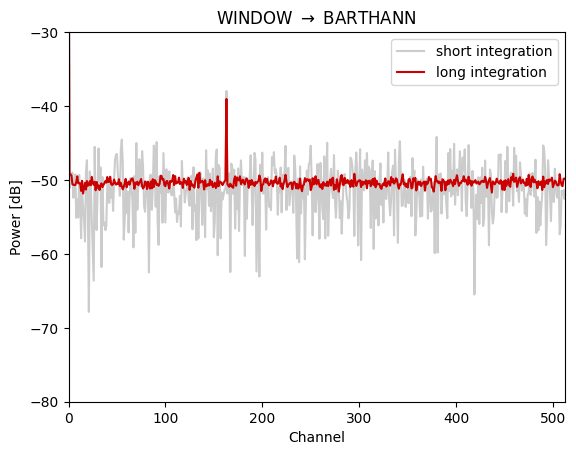

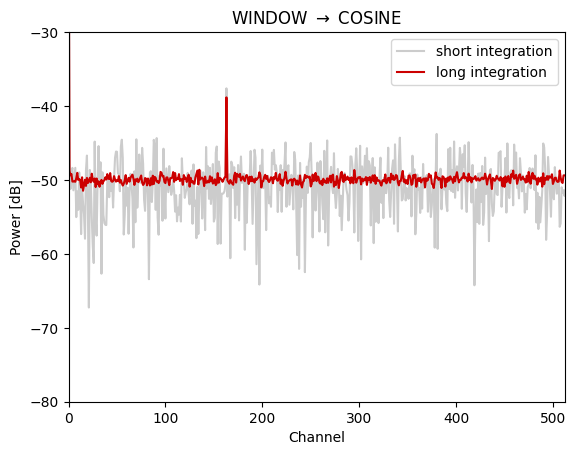

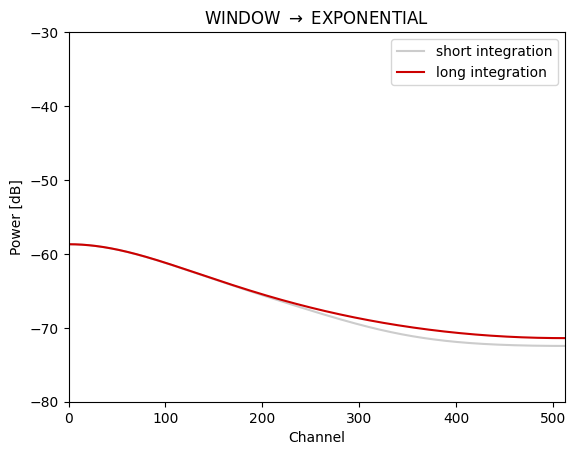

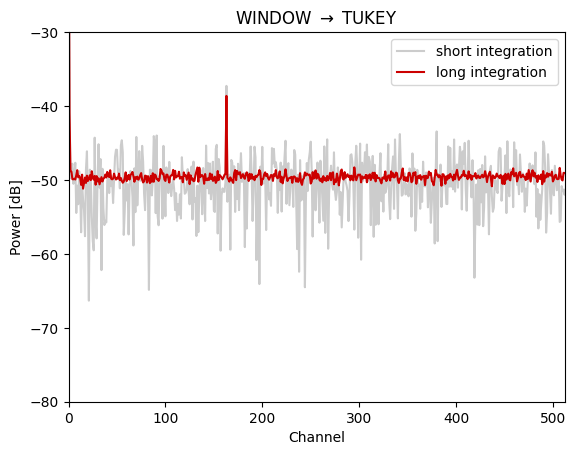

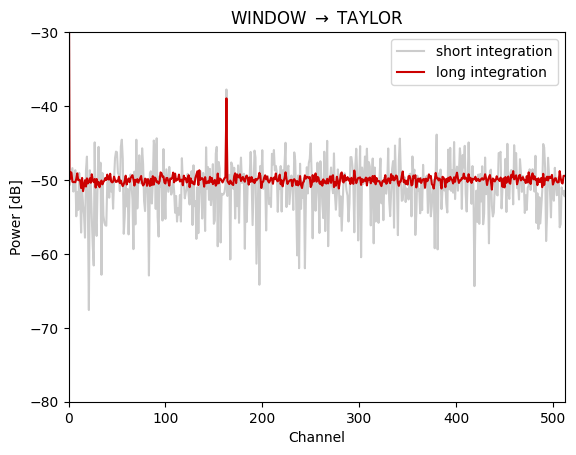

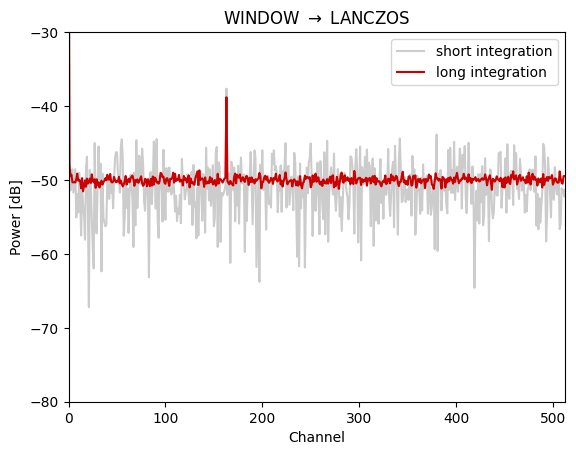

In [9]:
for indx, win in enumerate(windowList):
    X_psd = pfb_spectrometer(data, n_taps=M, n_chan=P, n_int=2, win_coeffs=win)
    X_psd2 = pfb_spectrometer(data, n_taps=M, n_chan=P, n_int=100, win_coeffs=win)

    plt.plot(db(X_psd[0]), c='#cccccc', label='short integration')
    plt.plot(db(X_psd2[1]), c='#cc0000', label='long integration')
    plt.ylim(-80, -30)
    plt.xlim(0, P/2)
    plt.xlabel("Channel")
    plt.title(f"WINDOW $\\rightarrow$ {names[indx]}")
    plt.ylabel("Power [dB]")
    plt.legend()
    plt.show()